## Importing Modules

In [10]:
from shapely.geometry import Point, LineString
import numpy as np
import rasterio
from rtree import index
import json
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs
import xml.etree.ElementTree as ET
import gpxpy.gpx

## Preprocessing

Background Map

In [11]:
sheepstor_map = rasterio.open(os.path.join('OS Explorer Maps','Download_South+Dartmoor_2004150','raster-25k_4541337','sx','sx56.tif'))

Links

<AxesSubplot:>

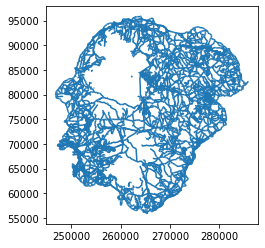

In [12]:
tree = ET.parse(os.path.join('Detailed-Path-Network','DARTMOOR NATIONAL PARK.gml'))
root = tree.getroot()
startNodes = [startNode.attrib for startNode in
              root.iter('{http://namespaces.os.uk/networks/detailedPathNetwork/1.0}startNode')]
startNodes = [nodes['{http://www.w3.org/1999/xlink}href'] for nodes in startNodes]
endNodes = [endNode.attrib for endNode in
            root.iter('{http://namespaces.os.uk/networks/detailedPathNetwork/1.0}endNode')]
endNodes = [nodes['{http://www.w3.org/1999/xlink}href'] for nodes in endNodes]
path_network = gpd.read_file(os.path.join('Detailed-Path-Network','DARTMOOR NATIONAL PARK.gml'))
path_network['startNodes'] = startNodes
path_network['endNodes'] = endNodes
path_network.plot()

Nodes

<AxesSubplot:>

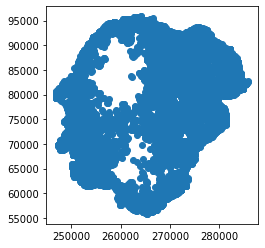

In [13]:
nodes_id = [nodes.attrib for nodes in root.iter('{http://namespaces.os.uk/networks/detailedPathNetwork/1.0}RouteNode') ]
nodes_id = [node['{http://www.opengis.net/gml/3.2}id'] for node in nodes_id]

network_coords = [geom.text for geom in root.iter('{http://www.opengis.net/gml/3.2}pos')]
node_coordinates = []
for i in network_coords:
    coords  = i.split(" ")
    coords = [float(j) for j in coords]
    node_coordinates.append(coords)

node_geom = [Point(node) for node in node_coordinates]

path_nodes = gpd.GeoDataFrame({'fid': nodes_id,'geometry':node_geom })
path_nodes.plot()

GPS Data

In [14]:
gpx_file = open(os.path.join('Walking routes','Bluebell walk.gpx'), 'r')

gpx = gpxpy.parse(gpx_file)

In [15]:
from pyproj import CRS
from pyproj import Transformer

wsg84 = CRS.from_epsg(4326)
osgb36 = CRS.from_epsg(27700)
transformer = Transformer.from_crs(wsg84, osgb36)

<AxesSubplot:>

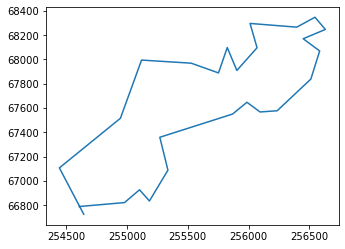

In [16]:
routes = gpx.routes
waypoints = routes[0].points
coords = []
#points = []
for waypoint in waypoints:
    coords.append(transformer.transform(waypoint.latitude,waypoint.longitude))
    #points.append(Point((transformer.transform(waypoint.latitude,waypoint.longitude))))
# points = pd.DataFrame({'coords':coords})
# points["fid"] = points.index
# points
bluebell_walk = gpd.GeoDataFrame(index=[0], crs='epsg:27700', geometry=[LineString(coords)])
bluebell_walk.plot()

## Finding the closest nodes

In [17]:
idx = index.Index()

# set the bounds for the index
for i in range(len(nodes_id)):
    left, bottom, right, top = (node_coordinates[i][0], node_coordinates[i][1],
                                node_coordinates[i][0],node_coordinates[i][1])
    idx.insert(i, (left, bottom, right, top))


In [18]:
start_point = coords[0]
end_point = coords[1]

In [19]:
for i in idx.nearest(start_point, 1):
    first_coordinate = node_coordinates[i]
    first_node = nodes_id[i]
for i in idx.nearest(end_point, 1):
    last_coordinate = node_coordinates[i]
    last_node = nodes_id[i]

In [20]:
first_node
first_node = ("#" + first_node)
print(first_node)
last_node
last_node = ("#" + last_node)
print(last_node)

#ID_6aa12d7f-91fd-4285-b556-1a4b6bcca219
#ID_fba52027-6b72-4eeb-a080-d348d2f09c89


## Creating the Network

In [21]:
g = nx.Graph()
for index,row in path_network.iterrows():
    g.add_edge(row['startNodes'], row['endNodes'], fid = row['gml_id'], weight = row['planimetricLength'])

## Find the path

In [22]:
path = nx.dijkstra_path(g,  first_node,   last_node, weight='weight')
path

['#ID_6aa12d7f-91fd-4285-b556-1a4b6bcca219',
 '#ID_6b95ae2c-9d88-4505-8fe8-fd7dee954701',
 '#ID_489ebaa4-7913-4f1f-ae81-76e2debfdb4c',
 '#ID_b90de1e1-24a8-4973-aa9c-70de95088338',
 '#ID_fba52027-6b72-4eeb-a080-d348d2f09c89']

## Creating the dataframe of the path

<AxesSubplot:>

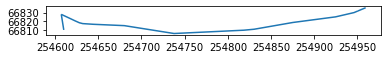

In [23]:
geom = []
links = []

first_node = path[0]
for node in path[1:]:
    link_fid = g.edges[first_node, node]['fid']
    links.append(link_fid)
    row = path_network.loc[path_network['gml_id'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

path_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})
path_gpd.plot()

## Plotting

In [24]:
back_array = sheepstor_map.read(1)
palette = np.array([value for key, value in sheepstor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = sheepstor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  if sys.path[0] == '':


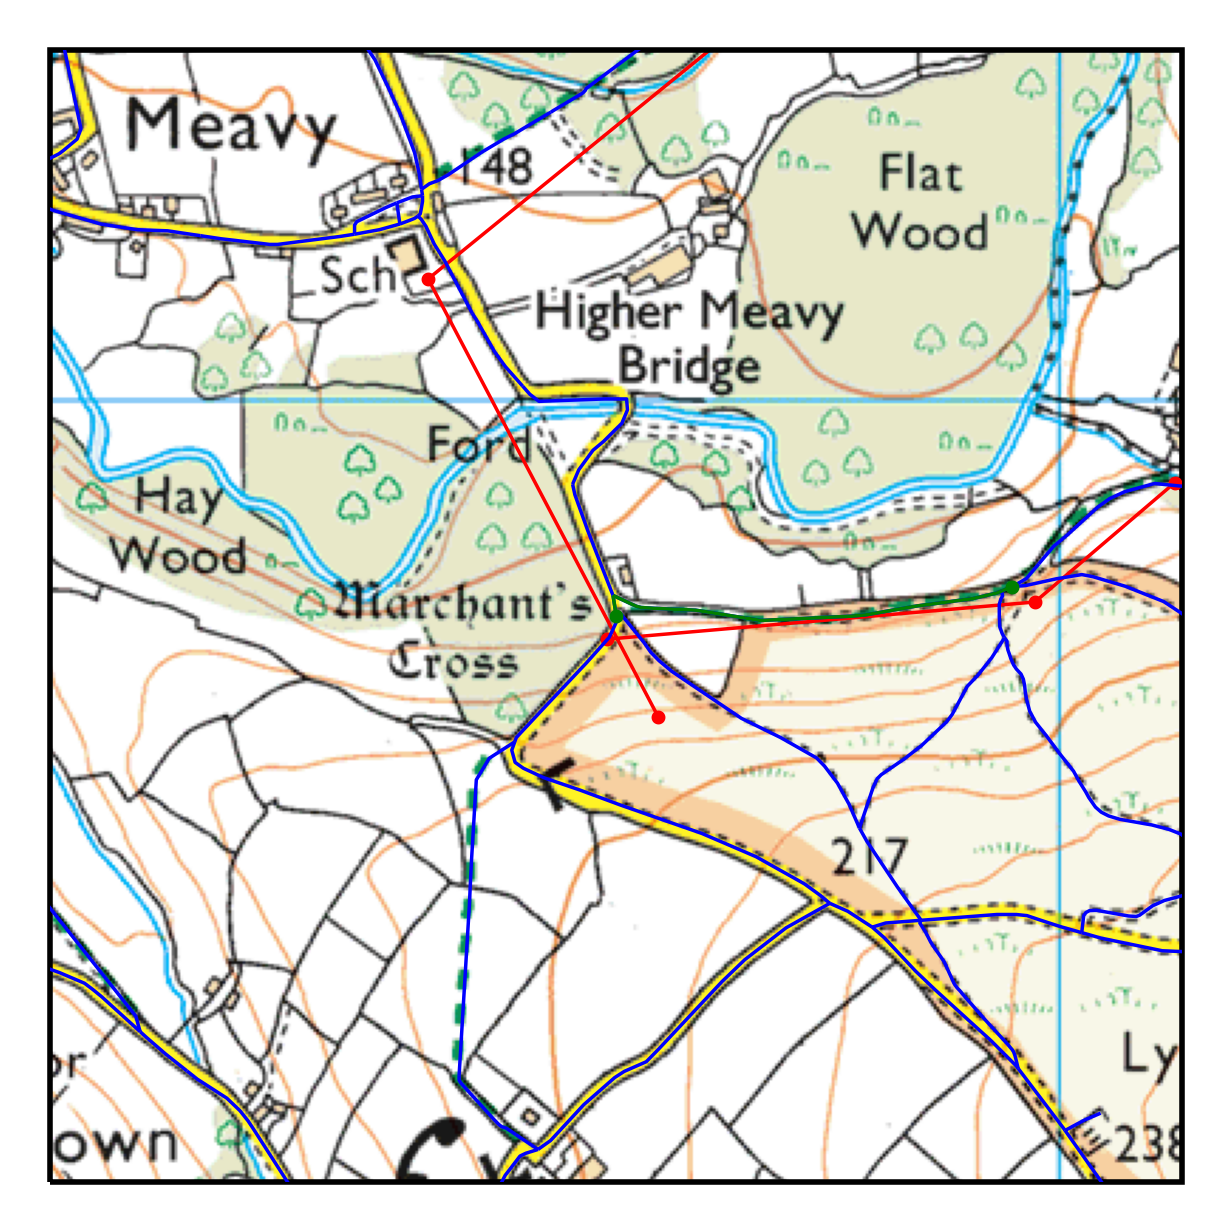

In [26]:
fig = plt.figure(figsize=(3, 3), dpi=500)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)
plt.scatter(first_coordinate[0], first_coordinate[1], color='green', s=1, zorder=5)
plt.scatter(last_coordinate[0], last_coordinate[1], color='green', s=1, zorder=5)
bluebell_walk.plot(ax=ax, edgecolor='red', linewidth=0.5, zorder=2)
plt.scatter(*zip(*coords),color='red', s=1, zorder=3)
path_network.plot(ax=ax, edgecolor='blue', linewidth=0.5, zorder=4)
path_gpd.plot(ax=ax, edgecolor='green', linewidth=0.5, zorder=5)
display_extent = ((first_coordinate[0] - 500, first_coordinate[0] + 500,
                          first_coordinate[1] - 500, first_coordinate[1] + 500))
ax.set_extent(display_extent,crs=crs.OSGB())
plt.show()